In [2]:
import numpy as np
import scipy.sparse as sp
import time
import os
import psutil
import shelve
from pybdm import BDM
from pybdm.utils import decompose_dataset
from joblib import Parallel, delayed
from joblib import parallel_backend
from data.algorithms import PerturbationExperiment, NodePerturbationExperiment
import math
import datetime
from itertools import product
import dbm.gnu

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/juan/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Loading BDM data from CMM

In [5]:
data_bdm = shelve.open("./data/data_structures/bdm")
for key in data_bdm:
    globals()[key]=data_bdm[key]
data_bdm.close()

In [7]:
print('Total Time:',datetime.timedelta(seconds=total_time))
print('Virtual Memory:',vms*1e-9,'Gb')
print('RSS Memory:',rss*1e-9,'Gb')
print('16 cores')

Total Time: 3 days, 1:13:16.250093
Virtual Memory: 4.583919616 Gb
RSS Memory: 2.214682624 Gb
16 cores


In [2]:
data_adj = shelve.open("./data/data_structures/decagon")
ddi_adj_list=data_adj['ddi_adj_list']
data_adj.close()

In [12]:
print(np.shape(bdm_ddi_list))
print(np.shape(ddi_adj_list))

(3, 2, 476)
(3,)


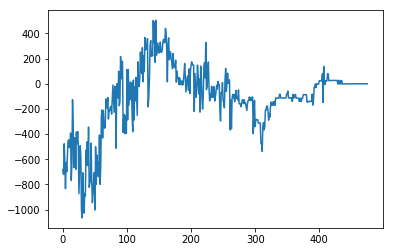

In [35]:
plot(bdm_ddi_list[0][1])
#plot(bdm_ddi_list[0][0])

## Username testing

In [37]:
from getpass import getuser
username = getuser()
print(username)
jobs = 16
filename ='ppi_bdm_'+ username + str(jobs)
print(filename)

juan
ppi_bdm_juan16


### Tests Parallelization

In [3]:
N = 16226
b = np.random.randint(0,2,(N,N))
X = ((b + b.T)/2).astype(int)
bdm = BDM(ndim=2)

In [ ]:
perturbation = NodePerturbationExperiment(bdm, metric='bdm',bipartite_network=False)
start = time.time()
perturbation.set_data(X)
perturbation.perturb(1)
print(time.time()-start)

In [4]:
start = time.time()
val = bdm.bdm(X)
print(time.time()-start)
print(val)

233.96441507339478
2181301.7438706793


In [5]:
start = time.time()
counters = Parallel(n_jobs=8)\
    (delayed(bdm.decompose_and_count)(d) for d in decompose_dataset(X, (4056, 4056)))

val = bdm.compute_bdm(*counters)
print(time.time()-start)
print(val)

89.67953491210938
2181301.7438706765


In [53]:
N = 1000
b = np.random.randint(0,2,(N,N))
X = ((b + b.T)/2).astype(int)
bdm = BDM(ndim=2)

In [54]:
perturbation = NodePerturbationExperiment(bdm, metric='bdm',bipartite_network=False,
                                         parallel=False)
start = time.time()
perturbation.set_data(X)
a = perturbation.run()
print(time.time()-start)
print(a[:5])

844.5500817298889
[350.29407194 624.10151908 488.90139065  11.91637723 290.29346832]


In [55]:
perturbation = NodePerturbationExperiment(bdm, metric='bdm',bipartite_network=False,
                                         parallel=True,jobs=8)
start = time.time()
perturbation.set_data(X)
perturbation.run()
print(time.time()-start)
print(a[:5])

300.7929446697235
[350.29407194 624.10151908 488.90139065  11.91637723 290.29346832]


# Time experiments (DO NOT DELETE!)
In this experiment we see time of execution in series and in parallel of the `run()` function of the class NodePerturbationExperiment with different matrix sizes.

In [9]:
# Data taken manually
N = np.array([10,50,100,200,400,500,700,800,900,1000])
S = np.array([0.030,0.114,0.813,6.7217,59.91,109.85,295.385,427.798,622.127,844.55])
P = np.array([1.20,4.129,7.370,22.910,52.55,68.289,122.082,166.802,225.77,300.792])

[85.11399523] [19.70275058]


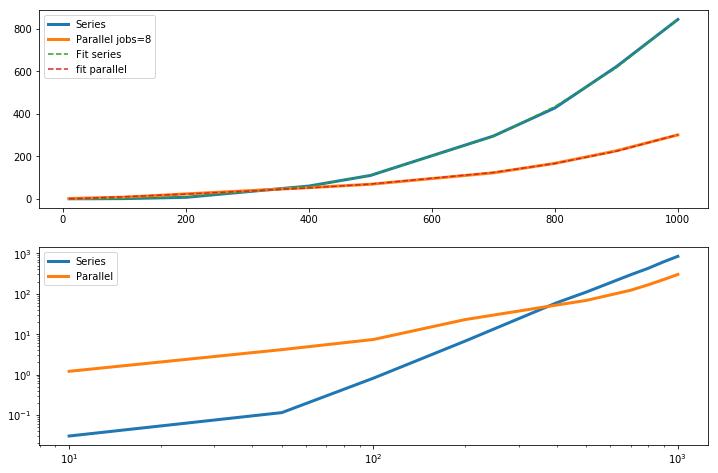

In [14]:
zs,rs,_,_,_ = np.polyfit(N,S,4,full=True)
p_ser = np.poly1d(zs)
zp,rp,_,_,_ = np.polyfit(N,P,4,full=True)
p_par = np.poly1d(zp)
print(rs,rp)
figure(figsize=[12,8])
subplot(2,1,1)
plot(N,S,label='Series',linewidth=3)
plot(N,P,label='Parallel jobs=8',linewidth=3)
plot(N,p_ser(N),'--',label='Fit series')
plot(N,p_par(N),'--',label='fit parallel')
legend()
subplot(2,1,2)
loglog(N,S,label='Series',linewidth=3)
loglog(N,P,label='Parallel',linewidth=3)
legend()
show()

In [15]:
print(datetime.timedelta(seconds=p_ser(16227)))
print(datetime.timedelta(seconds=p_par(16227)))

142 days, 6:42:55.613835
223 days, 23:33:53.494488
